In [1]:
from jax import config
import jax 
import jax.numpy as jnp

### Restricting the usage to the CPU
jax.config.update('jax_default_device', jax.devices('cpu')[0])

# # JAX supports single-precisions numbers by default.For double precision, use:
# # https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html
config.update("jax_enable_x64", True)

## 1. Basis functions ($\delta = \pi/2$)

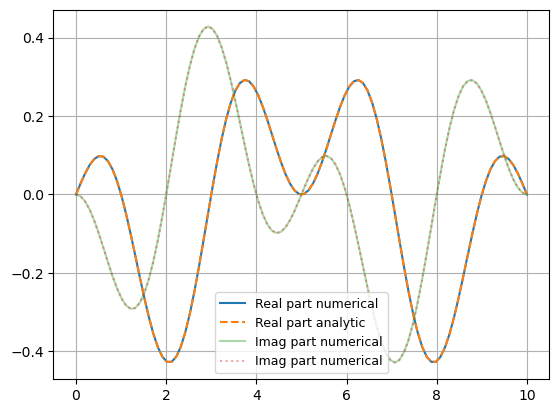

In [ ]:
from functions_sines_complex import sine_basis_func_tarr

nmax =5 # maximum number of harmonics to be called
twidth=10 #width of the pulse
tvals=jnp.linspace(0, twidth, 100)
delta = jnp.pi/2

narr = jnp.arange(1, nmax + 1)
(funcs_real, funcs_imag) = sine_basis_func_tarr(tvals, narr, delta, twidth)

###########################################################################
### Analytic expressions:
nind = 2 ### Should be less than nmax
omega = (nind * jnp.pi) / twidth
funcs_real_analy = jnp.sqrt(2/twidth)*jnp.sin(omega * tvals) * jnp.cos(delta * tvals)
funcs_imag_analy = -jnp.sqrt(2/twidth)*jnp.sin(omega * tvals) * jnp.sin(delta * tvals)

#########################################################################
import matplotlib.pyplot as plt
plt.plot(tvals, funcs_real[:,nind-1], label='Real part numerical')
plt.plot(tvals, funcs_real_analy, '--', label='Real part analytic')
plt.plot(tvals, funcs_imag[:,nind-1], alpha=0.4, label='Imag part numerical')
plt.plot(tvals, funcs_imag_analy, ':', alpha=0.4, label='Imag part numerical')

plt.legend(prop={'size':9},ncol=1)
plt.grid()

## 2. QFI as a function of frequencies: 

In [ ]:
from functions_optimization_complex import glb_finfo

#########################################################################################
gamma_cap=1.0 ### Gamma
avg_phot_num = 1.0
detuning = 0.35

num_basis_funcs=250
twidth = 500

#############################################################################
### Starting the pulse in different basis functions 
### (we will take different rows to be coefficients):
pulse_coefs = jnp.identity(2*num_basis_funcs)

# Ignoring the cases with 1j in front, since it is overall phase
pulse_coefs = pulse_coefs[0:num_basis_funcs,:]

### Setting in_axes=0, the function is applied along each row
finfo_final_vec = jax.jit(jax.vmap(glb_finfo, in_axes=(0, None, None)))
finfo_final = finfo_final_vec(pulse_coefs, detuning, twidth)

finfo_final[-1]

Array(1.33940974, dtype=float64)

### 2a. Plotting the results:

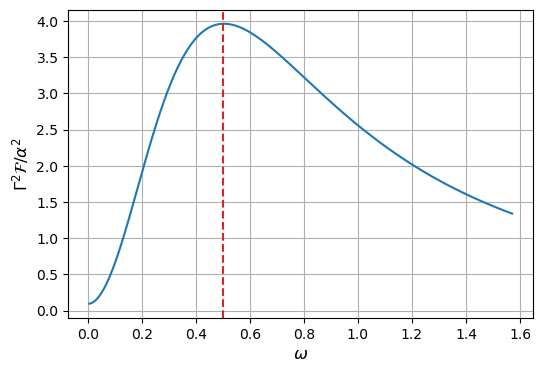

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, 1, figsize=(6,4))

ax1.plot(jnp.arange(1,num_basis_funcs+1,dtype=int)*(jnp.pi/twidth),finfo_final)
ax1.axvline(x = 0.5,color='tab:red', ls='--')
ax1.set_xlabel("$\omega$", size=12)
plt.ylabel(r'$\Gamma^{2}\mathcal{F}/\alpha^{2}$', size=12)
plt.grid()


## 3. Optimizer demonstration (~ 2min for evaluation):

In [5]:
from functions_optimization_complex import sing_inst_optimum_lbfgsb
from jax import random

avg_num_phot = 1.0
twidth = 500
detuning = 1.0
num_basis_funcs=150

### Picking random pulse coefficients between 0.0 and 1.0
key = random.PRNGKey(43911)
ini_seed = random.uniform(
    key, shape=(2*num_basis_funcs), minval=0.01, maxval=1.0)

### Collecting the results of the optimizer 
(opt_coef, opt_qfi, 
 opt_success)= sing_inst_optimum_lbfgsb(ini_seed, avg_num_phot, detuning, twidth)

print("Success:", opt_success)
print("Optimal QFI:",opt_qfi)


Success: 1.0
Optimal QFI: 3.9727554420816484


### 3a. Plotting optimal pulse coefficients:

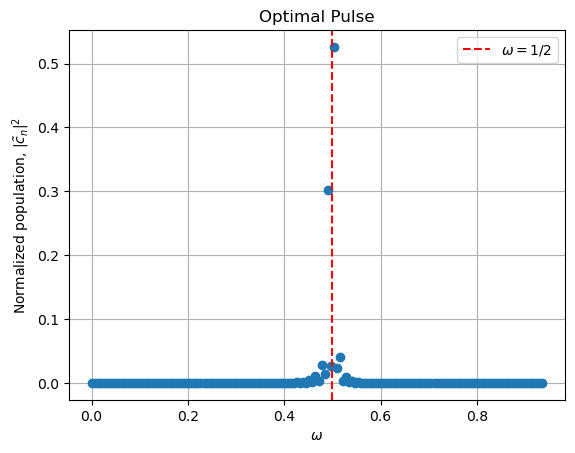

In [6]:
import matplotlib.pyplot as plt
import numpy as np

nmax = int(len(opt_coef)/2)  
coef_real = opt_coef[0:nmax]
coef_imag = opt_coef[nmax:]
coef = coef_real + 1j*coef_imag

### Plot
plt.plot(np.arange(0,num_basis_funcs)*(np.pi/twidth), np.abs(coef)**2/avg_num_phot,'o')
plt.axvline(0.5,ls='--', color='red', label=r'$\omega=1/2$')
plt.title("Optimal Pulse")
plt.xlabel(r"$\omega$")
plt.ylabel(r"Normalized population, $|\tilde{c}_{n}|^{2}$")
plt.legend()
plt.grid()
plt.show()


## 3. Optimizing over a range of $\alpha^{2}$ with three seeds and LBFGS optimizer (~25 min for evaluation ):

In [ ]:
### In this notebook, we use smaller twidth and less number of basis functions
### only for the sake of quick simulations. 

### Parameters:
import numpy as np
import concurrent.futures as cf
from functions_optimization_complex import multi_inst_optimum_lbfgsb

########################################################################
### Parameters:
num_basis_funcs = 150
twidth=300.0
detuning = 1.0
num_rseeds = 2 ## number of random seeds

start=-2.0#10.0**-2
end=4.0#10.0**4
avg_num_phot_vec =np.logspace(start, end, 20, endpoint=True)

num_threads = 3 ### Define the number of threads (cores) you want to use

#########################################################################
### Storing optimzer solution:
opt_coef_vec = np.zeros([len(avg_num_phot_vec), num_rseeds*2*num_basis_funcs])
opt_finfo_vec = np.zeros([len(avg_num_phot_vec),num_rseeds])
opt_success_vec = np.zeros([len(avg_num_phot_vec),num_rseeds])

### Performing parallel simulations on three different cores:
with cf.ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Submit the tasks to the executor:
    futures = {executor.submit(multi_inst_optimum_lbfgsb, num_rseeds,
                               avg_num_phot_vec[ind1], num_basis_funcs,
                               detuning, twidth): ind1
               for ind1 in range(len(avg_num_phot_vec))}
    
    # Wait for all futures to complete and store results in width_vals:
    dummy=0
    for future in cf.as_completed(futures):
        print(dummy, end='\r', flush=True)
        dummy+=1
        ind1 = futures[future]  # Get the index of the result from the dictionary
        (opt_coef_vec[ind1,:],
          opt_finfo_vec[ind1,:],
          opt_success_vec[ind1,:]) = future.result()  # Store the result in the correc
        

### prints true if every optimization is successful:
temp = jnp.any(opt_success_vec == 1, axis=1) #checking if at least one seed succeded
print(jnp.all(temp**1.0 == 1)) # min of one seed success for every alpha


True


### 3a. Plotting optimal QFI:

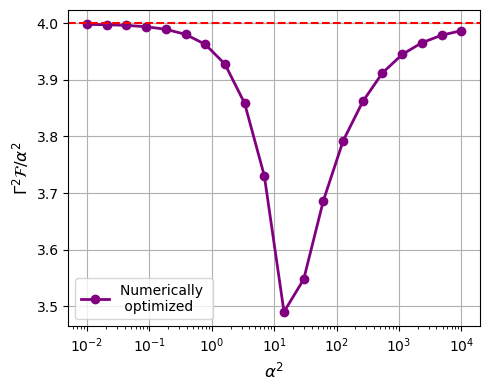

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


fig = plt.figure(figsize=(5.0, 4.0)) 
plt.semilogx(avg_num_phot_vec, np.max(opt_finfo_vec, axis=1),'o-',color='purple', lw=2, label='Numerically \n optimized')
plt.axhline(y=4,ls='--', color='red')

plt.xlabel(r'$\alpha^{2}$', size=12)
plt.ylabel(r'$\Gamma^{2}\mathcal{F}/\alpha^{2}$', size=12)
plt.tick_params(labelsize=10)
plt.grid(True)

# Get the current axes
ax = plt.gca()
# Set minor ticks ONLY on the x-axis (log scale)
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=range(2, 10), numticks=100))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())  # optional: hide minor labels

plt.tight_layout()
plt.xscale('log')           # make x-axis logarithmic
plt.legend(prop={'size':10},ncol=1)
plt.show()

### 3b. Plotting optimal pulse coefficients:

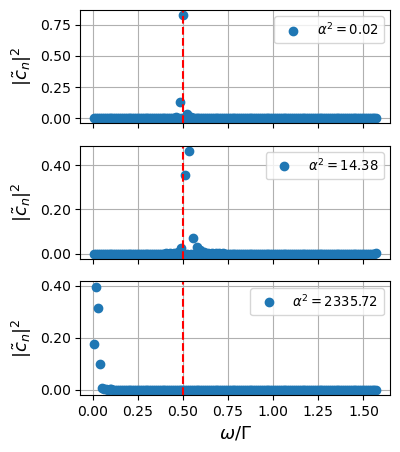

In [11]:
fig, (ax3a, ax3b, ax3c) = plt.subplots(3, 1, sharex=True, figsize=(4, 5))

############################################################################
max_indices = np.argmax(opt_finfo_vec, axis=1)

ind1=1 #
ind2=10
ind3=17
alpha2_1 = avg_num_phot_vec[ind1]
alpha2_2 = avg_num_phot_vec[ind2]
alpha2_3 = avg_num_phot_vec[ind3]
seed_num1 = max_indices[ind1]
seed_num2 = max_indices[ind2]
seed_num3 = max_indices[ind3]

#################################################################################
### Taking care of the complex coefficients:
narr = np.arange(1,num_basis_funcs+1,1)

opt_coef1 = opt_coef_vec[ind1,seed_num1*2*num_basis_funcs:(seed_num1+1)*2*num_basis_funcs]
opt_coef2 = opt_coef_vec[ind2,seed_num2*2*num_basis_funcs:(seed_num2+1)*2*num_basis_funcs]
opt_coef3 = opt_coef_vec[ind3,seed_num3*2*num_basis_funcs:(seed_num3+1)*2*num_basis_funcs]

(coef_real1, coef_imag1) = (opt_coef1[0:nmax], opt_coef1[nmax:])
(coef_real2, coef_imag2) = (opt_coef2[0:nmax], opt_coef2[nmax:])
(coef_real3, coef_imag3) = (opt_coef3[0:nmax], opt_coef3[nmax:])

coef1 = coef_real1 + 1j*coef_imag1
coef2 = coef_real2 + 1j*coef_imag2
coef3 = coef_real3 + 1j*coef_imag3

###########################################################################################################
pop1 = np.abs(coef1)**2
pop2 = np.abs(coef2)**2
pop3 = np.abs(coef3)**2
ax3a.plot(narr*(np.pi/twidth),(1/np.sum(pop1))*pop1,'o', label=r'$\alpha^{2} = %g$'% np.round((alpha2_1),2))
ax3b.plot(narr*(np.pi/twidth),(1/np.sum(pop2))*pop2,'o', label=r'$\alpha^{2} = %g$'% np.round((alpha2_2),2))
ax3c.plot(narr*(np.pi/twidth),(1/np.sum(pop3))*pop3,'o', label=r'$\alpha^{2} = %g$'% np.round((alpha2_3),2))

ax3a.axvline(x=0.5, ls='dashed', color='red')
ax3b.axvline(x=0.5, ls='dashed', color='red')
ax3c.axvline(x=0.5, ls='dashed', color='red')
#################################################################################
ax3a.legend(fontsize=9.5, loc='upper right')
ax3b.legend(fontsize=9.5, loc='upper right')
ax3c.legend(fontsize=9.5, loc='upper right')
ax3a.grid(True)
ax3b.grid(True)
ax3c.grid(True)
ax3a.tick_params('x', labelbottom=False)
ax3b.tick_params('x', labelbottom=False)
ax3c.set_xlabel(r'$\omega/\Gamma$', size=13)
ax3a.set_ylabel(r'$|\tilde{c}_{n}|^{2}$', size=13)
ax3b.set_ylabel(r'$|\tilde{c}_{n}|^{2}$', size=13)
ax3c.set_ylabel(r'$|\tilde{c}_{n}|^{2}$', size=13)

import matplotlib.ticker as ticker
fmt = ticker.FormatStrFormatter('%.2f')   # always show 2 decimals
for ax in (ax3a, ax3b, ax3c):
    ax.yaxis.set_major_formatter(fmt)

plt.show()

In [ ]:
### Saving data:
# np.savez(f"QFI_optimization_complex_{start}_{end}avgphotons_{num_basis_funcs}basis_funcs_harmonics_complex_sines_{detuning}detuning_{twidth}twidth_{num_rseeds}rseeds", 
#          optimized_pulse = opt_coef_vec, optimized_finfo = opt_finfo_vec,
#          optimized_success = opt_success_vec, avg_num_phot = avg_num_phot_vec)


